In [1]:
%matplotlib inline
%load_ext tensorboard
import os
import imageio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import binary_erosion
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torch.nn import functional as F
from torchsummary import summary
from torchvision import transforms
import skimage
import skimage.io
import skimage.segmentation
import glob

import utils
import os
import zarr
import gunpowder as gp

from functools import partial

import scipy
import tqdm
from datetime import datetime

In [2]:
train_data_path = "data/N3DHSIMDataset_01.n5"
val_data_path = "data/N3DHSIMDataset_02.n5"

In [3]:
class Dataset_3DT(Dataset):
    def __init__(self, input_zarr_paths, out_size=(16, 128, 128), x_limit=[0, 1.0], output_mode=None):
        """ ZYX
        """
        ## expects zarr file with at least raw data
        
        self.input_zarr_paths = input_zarr_paths
#         self.datasource = zarr.open(self.input_z_arr_path)  # not actually used
#         self.data_shape = self.datasource['raw'].shape

        self.out_size = out_size
        self.output_mode = output_mode
        
        # use limits in the x dim to create train / validation dataset
        self.x_limit = x_limit
#         self.x_limit = (self.data_shape[-1] * np.asarray(x_limit)).astype(np.int)
#         self.x_limit = self.x_limit[0], np.diff(self.x_limit)[0]
#         print("x offset {}, x len {}".format(*self.x_limit))

        self.build_pipelines()
        
        self.build_augmentations()
        
    def build_augmentations(self):
        # basic augmentations
        # rotates only in xy planes
        
        self.augs = list()
        self.augs.append(partial(np.flip, axis=-1))
        self.augs.append(partial(np.flip, axis=-2))
        self.augs.append(partial(np.flip, axis=-3))
        self.augs.append(partial(np.rot90, k=np.random.randint(1, 3), axes=(-1, -2)))
#         self.augs.append(partial(np.rot90, k=np.random.randint(1, 3), axes=(-2, -3)))
#         self.augs.append(partial(np.rot90, k=np.random.randint(1, 3), axes=(-3, -1)))
        self.augs.append(partial(np.rot90, k=np.random.randint(1, 3), axes=(-2, -1)))
#         self.augs.append(partial(np.rot90, k=np.random.randint(1, 3), axes=(-3, -2)))
#         self.augs.append(partial(np.rot90, k=np.random.randint(1, 3), axes=(-1, -3)))


    def build_pipelines(self):
        self._raw = gp.ArrayKey('raw')
        self._ground_truth = gp.ArrayKey('GT')
#         self.datasources = list()
        self.pipelines = list()
        for path in self.input_zarr_paths:
            assert 'raw' in zarr.open(path), "'raw' key require but not found in target zarr file"
            assert 'GT' in zarr.open(path), "'GT' key require but not found in target zarr file"
            
            raw_data_shape = zarr.open(path)['raw'].shape
            print(raw_data_shape)
            
            x_limit = (raw_data_shape[-1] * np.asarray(self.x_limit)).astype(np.int)
            x_limit = x_limit[0], np.diff(x_limit)[0]
            print("file [{}]: x offset {}, x len {}".format(path, *x_limit))
            
            raw_source = gp.ZarrSource(
                path,
                {self._raw: 'raw', },
                {self._raw: gp.ArraySpec(gp.Roi((0, 0, 0, x_limit[0]),
                                                (raw_data_shape[0],raw_data_shape[1],
                                                 raw_data_shape[2], x_limit[1])),
                                         interpolatable=True,
    #                                      voxel_size=(1, 200, 125, 125)
                                        )},
                )
            
            gt_source = gp.ZarrSource(
                path,
                {self._ground_truth: 'GT', },
                {self._ground_truth: gp.ArraySpec(gp.Roi((0, 0, 0, x_limit[0]),
                                                         (raw_data_shape[0], raw_data_shape[1],
                                                          raw_data_shape[2], x_limit[1])),
                                                  interpolatable=True,
    #                                               voxel_size=(1, 200, 125, 125)

                                                 )},
                )
            
            comb_source = (raw_source, gt_source) + gp.MergeProvider()        

            random_location = gp.RandomLocation()

            random_sample = comb_source + random_location
            
            self.pipelines.append(random_sample)
            
        self.basic_request = gp.BatchRequest()
        self.basic_request[self._raw] = gp.Roi((0, 0, 0, 0),
                                               (1, self.out_size[0], self.out_size[1], self.out_size[2]))
        self.basic_request[self._ground_truth] = gp.Roi((0, 0, 0, 0),
                                                        (1, self.out_size[0], self.out_size[1], self.out_size[2]))
        
    def modify_ground_truth(self, ground_truth):
#         print(ground_truth.shape)
        if self.output_mode is None:
            return ground_truth
        elif self.output_mode == "binary":
            return ground_truth.astype(bool)
        elif self.output_mode == "dt":
            return scipy.ndimage.distance_transform_edt(ground_truth)
        elif self.output_mode == "sdt":
            ground_truth = ground_truth.astype(bool)
            positives = scipy.ndimage.distance_transform_edt(ground_truth)
            negatives = -scipy.ndimage.distance_transform_edt(~ground_truth)
            return positives + negatives
        else:
            raise Exception("{} is an unrecognised output mode.".format(self.output_mode))

    def __getitem__(self, key, p_threshold=0.01):
        random_pipelines_index = np.random.randint(0, len(self.pipelines))
        # equal chance of picking from any file, does not balance for difference in bg between file
#         print("Picking sample from {}".format(self.input_zarr_paths[random_pipelines_index]))
        
        pipeline = self.pipelines[random_pipelines_index]
        
        with gp.build(pipeline):
            good_data = False            
            while not good_data:
                batch = pipeline.request_batch(self.basic_request)
#                 print(batch[self._ground_truth].data.astype(bool).sum()/batch[self._ground_truth].data.astype(bool).size)
                good_data = batch[self._ground_truth].data.astype(bool).sum() \
                            / batch[self._ground_truth].data.astype(bool).size > p_threshold # basically rejector

        data_roi, ground_truth_roi = batch[self._raw].data, batch[self._ground_truth].data    
    
        # adding noise to data
        data_roi = data_roi + np.random.normal(0, 10, size=data_roi.shape)
    
        # adding augmentations to both data and ground truth
        for aug in self.augs:
            if np.random.rand() > 0.5:
                data_roi = aug(data_roi)
                ground_truth_roi = aug(ground_truth_roi)
                
        # normalize
        data_roi = data_roi - data_roi.min()
        data_roi = data_roi / (data_roi.max() * np.random.uniform(0.8, 1.2))

        # change output type
        ground_truth_roi = self.modify_ground_truth(ground_truth_roi)
                
        return data_roi.copy(), ground_truth_roi.copy()

    
    def __len__(self):
        # completely arbitrary for now
        return 32*4

In [4]:
# using left half of training dataset for validation
train_dataset = Dataset_3DT([train_data_path, val_data_path], out_size=(32, 64, 64), x_limit=[0, 0.5], output_mode="binary")
print(len(train_dataset))
# train_dataset[0]

# val_dataset = Dataset_3DT(val_data_path, out_size=(32, 64, 64))
# print(len(val_dataset))
# # val_dataset[0]

# using right half of training dataset for validation
val_dataset = Dataset_3DT([train_data_path, val_data_path], out_size=(32, 64, 64), x_limit=[0.5, 1.0], output_mode="binary")
print(len(val_dataset))

(150, 59, 349, 639)
file [data/N3DHSIMDataset_01.n5]: x offset 0, x len 319
(80, 59, 642, 652)
file [data/N3DHSIMDataset_02.n5]: x offset 0, x len 326
128
(150, 59, 349, 639)
file [data/N3DHSIMDataset_01.n5]: x offset 319, x len 320
(80, 59, 642, 652)
file [data/N3DHSIMDataset_02.n5]: x offset 326, x len 326
128


In [5]:
# this data loader will serve 8 images in a "mini-batch" at a time
train_dataloader = DataLoader(train_dataset, batch_size=32,)
val_dataloader = DataLoader(val_dataset, batch_size=32,)

float64 bool
float64 bool


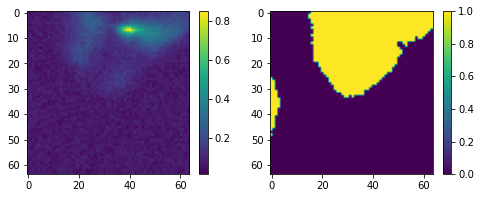

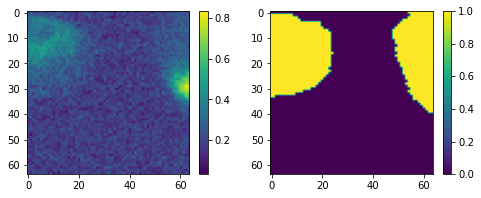

In [6]:
def plot_slice_from_volume(data, mask):
    fig, axes = plt.subplots(1, 2, figsize=(8,3))
    z = np.argmax(data.sum(axis=(-2,-1)), axis=1)[0] # axis 1
#     print(z)
    _im = axes[0].imshow(data[0, z, ...])
    plt.colorbar(_im, ax = axes[0])
    _im = axes[1].imshow(mask[0, z, ...])
    plt.colorbar(_im, ax = axes[1])
    print(data.dtype, mask.dtype)
    
for data, ground_truth in train_dataset:
    break

plot_slice_from_volume(data, ground_truth)

for data, val in val_dataset:
    break

plot_slice_from_volume(data, val)

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    print("! GPU available. Using CPU")
    device.torch.device('cpu')

In [8]:
class Unet3D(torch.nn.Module):
    
    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
                             nn.GroupNorm(in_channels, in_channels),
                             nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
                             nn.ReLU(),
                             nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
                             nn.ReLU())       


    # upsampling via transposed 2d convolutions
    def _upsampler(self, in_channels, out_channels):
        return nn.ConvTranspose3d(in_channels, out_channels,
                                kernel_size=2, stride=2)
    
    def __init__(self, depth=5, final_activation=None):
        super(Unet3D, self).__init__()
        self.depth = depth
        
        # the final activation must either be None or a Module
        if final_activation is not None:
            assert isinstance(final_activation, nn.Module), "Activation must be torch module"
            
        self.activation = final_activation
        
        # modules of the encoder path
        self.encoder = nn.ModuleList()
    
        # modules of the encoder path
        self.decoder = nn.ModuleList()
        
        # the upsampling layers
        self.upsamplers = nn.ModuleList()
        
        first_layer_out_channels = 16
        
        for i in np.arange(self.depth):
            self.encoder.append(self._conv_block(1 if i == 0 else 2**(i-1) * first_layer_out_channels,
                                                 2**i * first_layer_out_channels))
        
            self.upsamplers.append(self._upsampler(2**(self.depth-i)*first_layer_out_channels,
                                                   2**(self.depth-i-1)*first_layer_out_channels))
        
            self.decoder.append(self._conv_block(2**(self.depth-i)*first_layer_out_channels,
                                                 2**(self.depth-i-1)*first_layer_out_channels))
        
        # the pooling layers; we use 2x2 MaxPooling
        self.poolers = nn.ModuleList([nn.MaxPool3d(2) for _ in range(self.depth)])
        
        self.base = self._conv_block(int(2**(self.depth-1) * first_layer_out_channels),
                                     (2**(self.depth) * first_layer_out_channels))
        
        self.dropout = nn.Dropout3d(0.25)
        
        self.out_conv = nn.Conv3d(first_layer_out_channels, 1, kernel_size=1)
        
    def forward(self, x):
        # apply encoder path
        encoder_out = []
        for level in range(self.depth):
            x = self.encoder[level](x)
            encoder_out.append(x)
            x = self.poolers[level](x)
            x = self.dropout(x)

#         apply base
        x = self.base(x)
        x = self.dropout(x)
        
# #         # apply decoder path
        encoder_out = encoder_out[::-1]
        for level in range(self.depth):
            x = self.upsamplers[level](x)
            x = self.decoder[level](torch.cat((x, encoder_out[level]), dim=1))
            x = self.dropout(x)
        
#         # apply output conv and activation (if given)
        x = self.out_conv(x)
        if self.activation is not None:
            x = self.activation(x)

        return x




# change depth, roi dimensions or batch size to fit in memory
summary(Unet3D(depth=5).to(device), ( 1, 32, 64, 64), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         GroupNorm-1        [32, 1, 32, 64, 64]               2
            Conv3d-2       [32, 16, 32, 64, 64]             448
              ReLU-3       [32, 16, 32, 64, 64]               0
            Conv3d-4       [32, 16, 32, 64, 64]           6,928
              ReLU-5       [32, 16, 32, 64, 64]               0
         MaxPool3d-6       [32, 16, 16, 32, 32]               0
         Dropout3d-7       [32, 16, 16, 32, 32]               0
         GroupNorm-8       [32, 16, 16, 32, 32]              32
            Conv3d-9       [32, 32, 16, 32, 32]          13,856
             ReLU-10       [32, 32, 16, 32, 32]               0
           Conv3d-11       [32, 32, 16, 32, 32]          27,680
             ReLU-12       [32, 32, 16, 32, 32]               0
        MaxPool3d-13        [32, 32, 8, 16, 16]               0
        Dropout3d-14        [32, 32, 8,

In [9]:
# attempt to fix werid image display on tensorboard
    
def normalize_to_int8(img):
    img -= img.min()
    return np.round(img / img.max() * 255)

def normalize_to_01(img):
    img = img.float()
    img = img - img.min()
    return img / img.max()

In [10]:
# apply training for one epoch
def train(model, loader, optimizer, loss_function,
          epoch, log_interval=100, log_image_interval=20, tb_logger=None):

    model.train()
    model.requires_grad_(True)
    
    # iterate over the batches of this epoch
    for batch_id, (x, y) in enumerate(loader):
        # move input and target to the active device (either cpu or gpu)
        x, y = x.to(device), y.to(device)
        
        # zero the gradients for this iteration
        optimizer.zero_grad()
        
        # apply model and calculate loss
        pred = model(x.float())
        
        # backpropagate the loss and adjust the parameters
        loss = loss_function(pred, y.float())
        loss.backward()
        optimizer.step()
        
        # log to console
        if batch_id % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_id * len(x),
                  len(loader.dataset),
                  100. * batch_id / len(loader), loss.item()))

       # log to tensorboard
        if tb_logger is not None:
            step = epoch * len(loader) + batch_id
            tb_logger.add_scalar(tag='train_loss', scalar_value=loss.item(), global_step=step)
            # check if we log images in this iteration
            if step % log_image_interval == 0:
                z = np.random.randint(0, x.shape[2])
                tb_logger.add_images(tag='input',
                                     img_tensor=normalize_to_01(x.to('cpu')[:, : , z, ...]).detach(), global_step=step)
                tb_logger.add_images(tag='target',
                                     img_tensor=normalize_to_01(y.to('cpu')[:, :, z, ...]).detach(), global_step=step)
                tb_logger.add_images(tag='prediction',
                                     img_tensor=normalize_to_01(pred.to('cpu')[:, :, z, ...].detach()), global_step=step)

In [11]:
# run validation after training epoch
def validate(model, loader, loss_function, metric, step=None, tb_logger=None):
#     set model to eval mode
    model.eval()
    # running loss and metric values
    val_loss = 0
    val_metric = 0
    
    # disable gradients during validation
    with torch.no_grad():
#     model.requires_grad_(False)
        
        # iterate over validation loader and update loss and metric values
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x.float())
            val_loss += loss_function(pred, y.float()).item()
            val_metric += metric(pred, y.float()).item()
            
    
    # normalize loss and metric
    val_loss /= len(loader)
    val_metric /= len(loader)
    
    if tb_logger is not None:
        assert step is not None, "Need to know the current step to log validation results"
        tb_logger.add_scalar(tag='val_loss', scalar_value=val_loss, global_step=step)
        tb_logger.add_scalar(tag='val_metric', scalar_value=val_metric, global_step=step)
        # we always log the last validation images
        z = np.random.randint(0, x.shape[2])
        tb_logger.add_images(tag='val_input',
                             img_tensor=normalize_to_01(x.to('cpu')[:, : , z, ...]).detach(), global_step=step)
        tb_logger.add_images(tag='val_target',
                             img_tensor=normalize_to_01(y.to('cpu')[:, : , z, ...]).detach(), global_step=step)
        tb_logger.add_images(tag='val_prediction',
                             img_tensor=normalize_to_01(pred.to('cpu')[:, : , z, ...]).detach(), global_step=step)
        
    print('\nValidate: Average loss: {:.4f}, Average Metric: {:.4f}\n'.format(val_loss, val_metric))

In [12]:
def save(target_path):
    torch.save({
    'epoch': epoch,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
#             'loss': LOSS,
    }, target_path)


In [13]:
# sorensen dice coefficient implemented in torch
# the coefficient takes values in [0, 1], where 0 is
# the worst score, 1 is the best score
class DiceCoefficient(nn.Module,):
    def __init__(self, eps=1e-6, as_lost_func=False):
        super().__init__()
        self.eps = eps
        self.as_lost_func = as_lost_func
        
    # the dice coefficient of two sets represented as vectors a, b ca be 
    # computed as (2 *|a b| / (a^2 + b^2))
    def forward(self, prediction, target):
        intersection = (prediction * target).sum()
        denominator = (prediction * prediction).sum() + (target * target).sum()
        out = (2 * intersection / denominator.clamp(min=self.eps))
        if self.as_lost_func:
            out *= -1
        return out

In [14]:
def setup_network(load_path=None):
    net = Unet3D(depth=5,)
    
    # use adam optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    
    # MSE loss
    loss_function = nn.MSELoss()
    
    metric = DiceCoefficient()
    
    if not load_path is None:
        checkpoint = torch.load(load_path)
        net.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        net.eval()
    
    return net, optimizer, loss_function, metric

net, optimizer, loss_function, metric = setup_network()
# net, optimizer, loss_function = setup_network("chk_point_0")

In [15]:
# start a tensorboard writer
%tensorboard --logdir runs

In [16]:
def train_and_validate(net, train_dataloader, val_dataloader, optimizer, loss_function, n_epochs=100, logger=None, checkpoints=None):
    # during the training you can inspect the 
    # predictions in the tensorboard
    
    net.to(device)
    
    for epoch in range(n_epochs):
        # train
        train(net, train_dataloader, optimizer, loss_function, epoch, tb_logger=logger)
        step = epoch * len(train_dataloader.dataset)
        # validate
        validate(net, val_dataloader, loss_function, metric, epoch, tb_logger=logger)
        if epoch in checkpoints:
            save(checkpoints[epoch])
            print("checkpoint, epoch {} saved at {}".format(epoch, checkpoints[epoch]))
            
train_and_validate(net,
                   train_dataloader,
                   val_dataloader,
                   optimizer, loss_function, 1,
                   SummaryWriter("runs/3D_Unet_{}".format(datetime.now().strftime("%Y%M%d_%H:%M:%S"))),
                   {i : "chk_point_{}".format(i) for i in np.arange(20, 1000, 20)})

Train Epoch: 0 [0/128 (0%)]	Loss: 0.169579

Validate: Average loss: 0.0716, Average Metric: 0.6943



In [17]:
def plot_predictions(net, dataloader):
    for batch_id, (x, y) in enumerate(dataloader):
        num_to_show = min([x.shape[0], 8])
        fig, axes = plt.subplots(num_to_show, 3, figsize=(10, 3*num_to_show))    
    #     print(x.dtype, y.dtype)
        x, y = x.to(device), y.double().to(device)
    #     print(x.type(), y.type())
        pred = net(x.float())

        z = y.sum((-2, -1)).argmax(2).squeeze()
        for i in np.arange(num_to_show):
            axes[i, 0].imshow(x[i,0,z[i],...].cpu().detach())
            _im = axes[i, 1].imshow(y[i,0,z[i],...].cpu().detach())
            plt.colorbar(_im, ax=axes[i,1])
            _im = axes[i, 2].imshow(pred[i,0,z[i],...].cpu().detach())
            plt.colorbar(_im, ax=axes[i,2])

        break

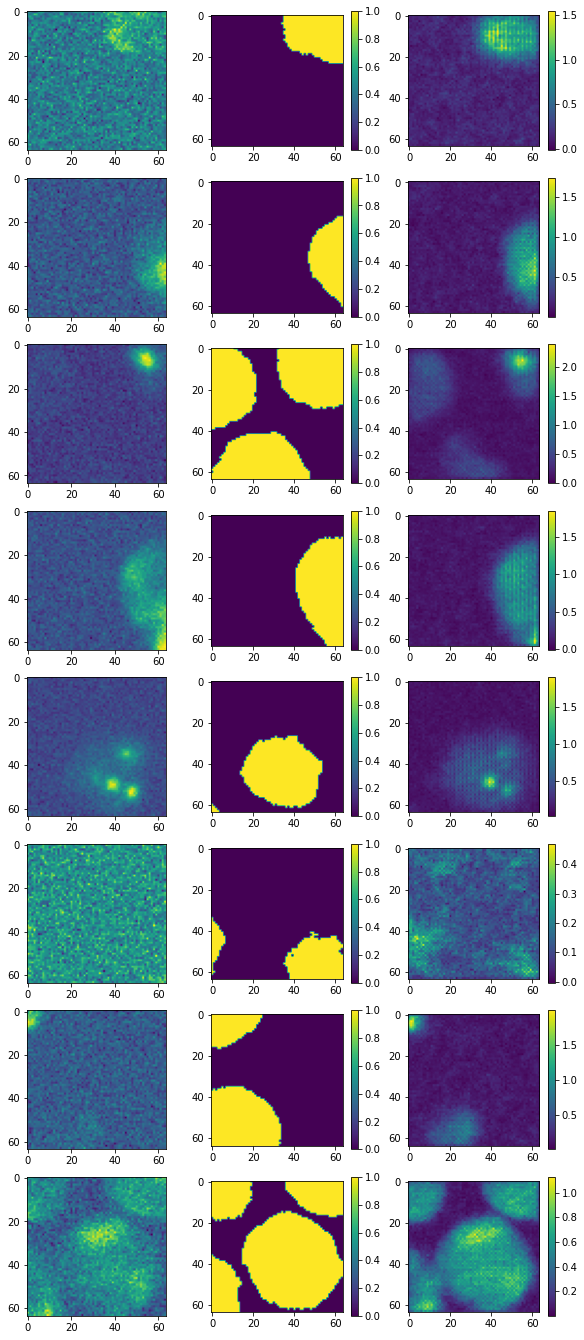

In [18]:
plot_predictions(net, train_dataloader)

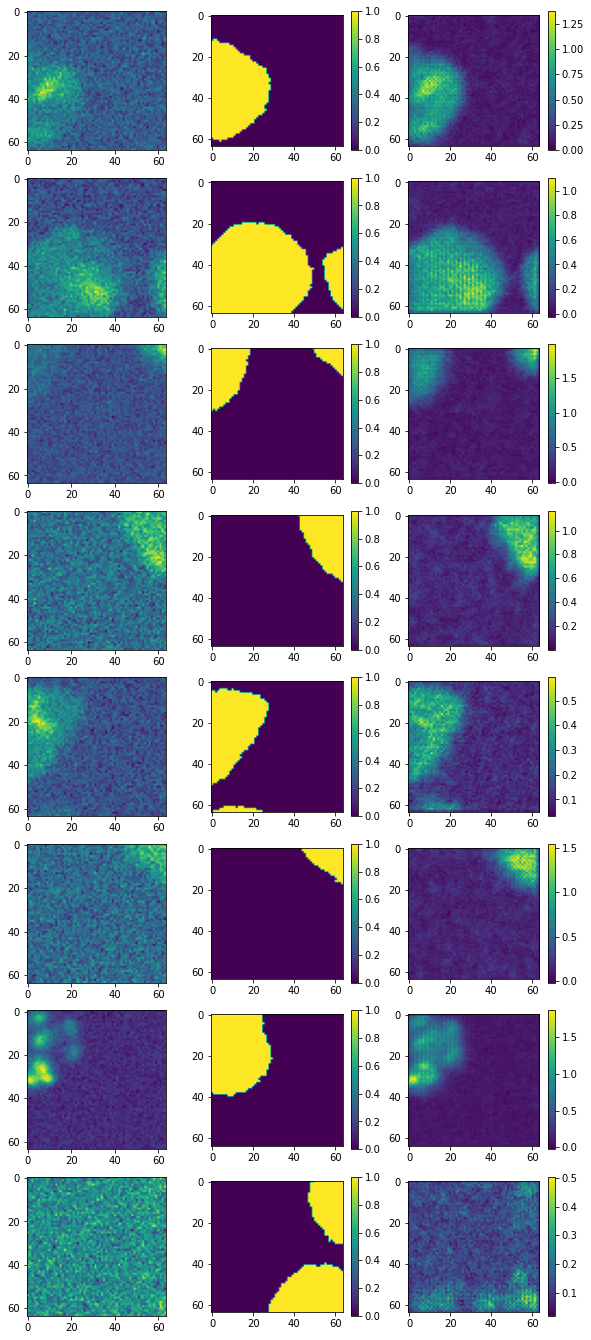

In [19]:
plot_predictions(net, val_dataloader)

In [20]:
# test_data_path = "data/N3DHSIMDataset_01.n5"
# test_data_key = "raw"

# model_prediction_path = "data/N3DHSIMDataset_01_pred.n5"
# model_prediction_key = "sdt"

# pred_file = zarr.open(model_prediction_path)
# pred_file[model_prediction_key] = np.zeros(zarr.open(test_data_path)[test_data_key].shape)

# print(pred_file[model_prediction_key])

In [21]:
# def predict_complete_dataset(net, source_path, source_key, target_path, target_key,
#                             model_input_shape):
    
#     source_array = zarr.open(source_path)[source_key]
    
#     print(raw_data.shape)
#     # 8, 1, 32, 64, 64

#     # predicted_volume = np.zeros(raw_data.shape)

#     def get_actual_slice(start, length, step):
#         stop = min(length, start+step)
#         start = stop - step
#         return slice(start, stop)

#     net.double()
#     net.cuda()

#     counter = 0
#     for t in np.arange(88, raw_data.shape[0], step=8):
#         print(t)
#     #     t1 = min(raw_data.shape[0], t+8)
#     #     t0 = t1 - 8
#         t_slice = get_actual_slice(t, raw_data.shape[0], 8)
#         print(t0, t1)
#         for z in tqdm.tqdm(np.arange(raw_data.shape[1], step=32)):
#             z_slice = get_actual_slice(z, raw_data.shape[1], 32)

#             for y in np.arange(raw_data.shape[2], step=64):
#                 y_slice = get_actual_slice(y, raw_data.shape[2], 64)

#                 for x in np.arange(raw_data.shape[3], step=64):
#                     x_slice = get_actual_slice(x, raw_data.shape[3], 64)

#     #                 print("slicing tzyx: {}, {}, {}, {}".format(t_slice, z_slice, y_slice, x_slice))
#     #                 predicted_volume[t_slice, z_slice, y_slice, x_slice] = 1
#     #                 crop = torch.tensor(raw_data[t_slice, z_slice, y_slice, x_slice].astype(np.double),
#     #                                     requires_grad = False,)
#                     crop = torch.as_tensor(raw_data[t_slice, z_slice, y_slice, x_slice].astype(np.double),
#                                                     device=torch.device('cuda'),)
#                     crop = crop.unsqueeze(1)
#     #                 crop = crop.cuda()
#     #                 print(crop.shape)
#     #                 print(crop.dtype)
#     #                 print(crop.is_cuda)
#     #                 print(crop.double())
#     #                 net(crop)
#                     predicted_volume[t_slice, z_slice, y_slice, x_slice] = net(crop).cpu().detach()[:,0,...]

#     #                 counter += 1
#     #                 if counter > 1000:
#     #                     sdfe
